# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "small.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [2]:
# Add your imports here
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
# Additional settings
pandas.set_option('display.max_columns', None)
sns.set_theme(style="white")

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [4]:
data.info()
data.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 30825 to 36815
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3602 non-null   object 
 1   Type 1             3607 non-null   object 
 2   Type 2             1916 non-null   object 
 3   HP                 3586 non-null   float64
 4   Attack             3627 non-null   float64
 5   Defense            3603 non-null   float64
 6   Sp. Atk            3633 non-null   float64
 7   Sp. Def            3608 non-null   float64
 8   Speed              3583 non-null   float64
 9   Generation         3589 non-null   float64
 10  Legendary          3614 non-null   object 
 11  Name__other        3594 non-null   object 
 12  Type 1__other      3576 non-null   object 
 13  Type 2__other      1945 non-null   object 
 14  HP__other          3619 non-null   float64
 15  Attack__other      3569 non-null   float64
 16  Defense__other     

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name__other,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
30825,Groudon,Ground,NaN,100.0,147.0,148.0,95.0,87.0,88.0,3.0,True,Hippopotas,Ground,NaN,68.0,71.0,79.0,42.0,40.0,30.0,4.0,False,True
42564,Miltank,Normal,NaN,95.0,78.0,103.0,45.0,74.0,102.0,2.0,False,Rayquaza,NaN,NaN,105.0,NaN,94.0,147.0,94.0,97.0,3.0,True,True
16498,Numel,Fire,Ground,60.0,62.0,41.0,65.0,49.0,39.0,4.0,False,Alomomola,Water,NaN,165.0,72.0,82.0,36.0,49.0,NaN,5.0,False,False
6597,Umbreon,Dark,NaN,95.0,NaN,111.0,56.0,129.0,65.0,2.0,False,NaN,NaN,Ground,80.0,117.0,127.0,107.0,59.0,47.0,1.0,False,True
39137,Mega Banette,Ghost,NaN,64.0,166.0,79.0,93.0,87.0,71.0,4.0,False,Hoppip,Grass,Flying,35.0,39.0,38.0,31.0,47.0,NaN,2.0,False,True
47574,Tympole,Water,NaN,50.0,53.0,47.0,51.0,36.0,68.0,NaN,False,Metagross,Grass,Psychic,123.0,134.0,134.0,89.0,88.0,64.0,3.0,False,False
41933,Flygon,Ground,Dragon,NaN,100.0,81.0,81.0,76.0,96.0,NaN,NaN,Skuntank,Poison,NaN,92.0,129.0,69.0,67.0,33.0,86.0,4.0,False,True
27206,Shedinja,Bug,Ghost,1.0,86.0,43.0,27.0,41.0,46.0,NaN,False,Seismitoad,Water,Ground,105.0,93.0,75.0,82.0,78.0,69.0,5.0,False,False
40688,Vulpix,Fire,NaN,44.0,37.0,47.0,51.0,NaN,61.0,1.0,False,Clawitzer,Water,NaN,71.0,81.0,86.0,120.0,85.0,62.0,6.0,False,True
8789,Wooper,Water,Ground,55.0,43.0,NaN,23.0,24.0,16.0,2.0,False,Quilava,Fire,NaN,58.0,71.0,59.0,83.0,61.0,75.0,2.0,False,False


In [5]:
categorical_df = data[['Name','Type 1','Type 2','Generation','Legendary','Name__other','Type 1__other','Type 2__other','Generation__other','Legendary__other','Wins']]
categorical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 30825 to 36815
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3602 non-null   object 
 1   Type 1             3607 non-null   object 
 2   Type 2             1916 non-null   object 
 3   Generation         3589 non-null   float64
 4   Legendary          3614 non-null   object 
 5   Name__other        3594 non-null   object 
 6   Type 1__other      3576 non-null   object 
 7   Type 2__other      1945 non-null   object 
 8   Generation__other  3633 non-null   float64
 9   Legendary__other   3608 non-null   object 
 10  Wins               4000 non-null   bool   
dtypes: bool(1), float64(2), object(8)
memory usage: 347.7+ KB


In [6]:
continuous_df = data[['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','HP__other','Attack__other','Defense__other','Sp. Atk__other','Sp. Def__other','Speed__other']]
continuous_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 30825 to 36815
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              3586 non-null   float64
 1   Attack          3627 non-null   float64
 2   Defense         3603 non-null   float64
 3   Sp. Atk         3633 non-null   float64
 4   Sp. Def         3608 non-null   float64
 5   Speed           3583 non-null   float64
 6   HP__other       3619 non-null   float64
 7   Attack__other   3569 non-null   float64
 8   Defense__other  3592 non-null   float64
 9   Sp. Atk__other  3565 non-null   float64
 10  Sp. Def__other  3584 non-null   float64
 11  Speed__other    3601 non-null   float64
dtypes: float64(12)
memory usage: 406.2 KB


2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot:>

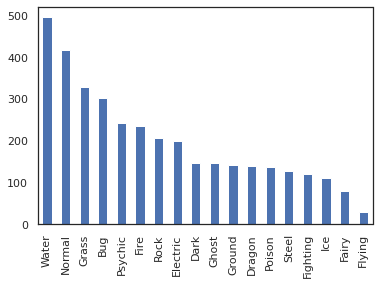

In [7]:
data['Type 1'].value_counts().plot(kind='bar')

3. Determine which of the features have missing values. How many missing values there are for each one?

In [8]:
# Columns with missing values
list(data.columns[data.isnull().any()])

['Name',
 'Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation',
 'Legendary',
 'Name__other',
 'Type 1__other',
 'Type 2__other',
 'HP__other',
 'Attack__other',
 'Defense__other',
 'Sp. Atk__other',
 'Sp. Def__other',
 'Speed__other',
 'Generation__other',
 'Legendary__other']

In [9]:
# Count Missing Values for each column
data.isnull().sum()

Name                  398
Type 1                393
Type 2               2084
HP                    414
Attack                373
Defense               397
Sp. Atk               367
Sp. Def               392
Speed                 417
Generation            411
Legendary             386
Name__other           406
Type 1__other         424
Type 2__other        2055
HP__other             381
Attack__other         431
Defense__other        408
Sp. Atk__other        435
Sp. Def__other        416
Speed__other          399
Generation__other     367
Legendary__other      392
Wins                    0
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

<AxesSubplot:>

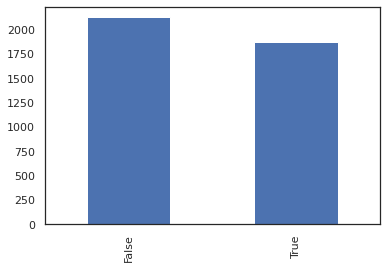

In [10]:
data['Wins'].value_counts().plot(kind='bar')

As we can see in the bar plot, the target column is well-balanced because all the the different values (in our case true or false) have more or less the same quantity.

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

In [11]:
# Data
processing_df = data

In [12]:
# Drop rows with missing values with too much data is also dangerous. It can 
# create significant bias by depriving your algorithms of space. This is especially true of classifiers sensitive 
# to the curse of dimensionality. In our case we start with 40.000 rows and if we clean it, we have 1400 rows.

# Encode Categorical Variables: Booleans (False =0, True = 1) 

processing_df['Wins'] = processing_df['Wins'].astype('Int64')
processing_df['Legendary__other'] = processing_df['Legendary__other'].map({False:0,True:1})
processing_df['Legendary'] = processing_df['Legendary'].map({False:0,True:1})

In [13]:
# Encode Categorical Data : Strings
# https://scikit-learn.org/stable/modules/preprocessing.html
# https://stackoverflow.com/questions/54444260/labelencoder-that-keeps-missing-values-as-nan

label_to_encode_name = ['Name','Name__other']
label_to_encode_type = ['Type 1','Type 2','Type 1__other','Type 2__other']

label_encoder_name = LabelEncoder()
label_encoder_type = LabelEncoder()

# Encode Pokemon Names
processing_df[label_to_encode_name] = processing_df[label_to_encode_name].apply(lambda series: pandas.Series(
    label_encoder_name.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

# Encode Pokemon Types
processing_df[label_to_encode_type] = processing_df[label_to_encode_type].apply(lambda series: pandas.Series(
    label_encoder_type.fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

print(label_encoder_name.classes_[:10])
print(label_encoder_type.classes_[:10])

['Abomasnow' 'Abra' 'Absol' 'Accelgor' 'Aegislash Blade Forme'
 'Aegislash Shield Forme' 'Aerodactyl' 'Aggron' 'Aipom' 'Alakazam']
['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass']


In [14]:
# Imputation Data

# A) Simple imputation
# imp_num = SimpleImputer(strategy='mean')
# imp_cat = SimpleImputer(strategy='most_frequent')

# B) Iterative Imputer
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    
# imp_num = IterativeImputer(estimator=RandomForestRegressor(),
#                            initial_strategy='mean',
#                            max_iter=1, random_state=0)

# imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
#                            initial_strategy='most_frequent',
#                            max_iter=1, random_state=0)

# categorical = list(categorical_df.columns)
# categorical.remove('Wins')
# numerical = continuous_df.columns

# processing_df[numerical] = imp_num.fit_transform(processing_df[numerical])
# processing_df[categorical] = imp_cat.fit_transform(processing_df[categorical])

# C) Impute Missing Values using KNN
# https://stackoverflow.com/questions/64900801/implementing-knn-imputation-on-categorical-variables-in-an-sklearn-pipeline
# https://towardsdatascience.com/going-beyond-the-simpleimputer-for-missing-data-imputation-dd8ba168d505
knn_imputer = KNNImputer(n_neighbors=1) # n_neighbors=1 avoid mean/average values
processing_df = knn_imputer.fit_transform(processing_df)
processing_df = pandas.DataFrame(processing_df,columns=data.columns)

processing_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Name__other,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
0,262.0,10.0,1.0,100.0,147.0,148.0,95.0,87.0,88.0,3.0,1.0,278.0,10.0,15.0,68.0,71.0,79.0,42.0,40.0,30.0,4.0,0.0,1.0
1,457.0,12.0,7.0,95.0,78.0,103.0,45.0,74.0,102.0,2.0,0.0,555.0,3.0,7.0,105.0,89.0,94.0,147.0,94.0,97.0,3.0,1.0,1.0
2,488.0,6.0,10.0,60.0,62.0,41.0,65.0,49.0,39.0,4.0,0.0,10.0,17.0,4.0,165.0,72.0,82.0,36.0,49.0,58.0,5.0,0.0,0.0
3,713.0,1.0,2.0,95.0,96.0,111.0,56.0,129.0,65.0,2.0,0.0,358.0,5.0,10.0,80.0,117.0,127.0,107.0,59.0,47.0,1.0,0.0,1.0
4,403.0,8.0,10.0,64.0,166.0,79.0,93.0,87.0,71.0,4.0,0.0,288.0,9.0,7.0,35.0,39.0,38.0,31.0,47.0,70.0,2.0,0.0,1.0


In [15]:
# Reduce dimensions of the dataset
processing_df = processing_df.drop(columns=['Legendary', 'Legendary__other','Generation','Generation__other','Type 2','Type 2__other'])
processing_df.info()
processing_df.head(20)

# Legendary variable defines the rarity to find this Pokemon. Therefore, doesn't affect the victory of the battle.
# Generation variable defines the seasson that the Pokemon appears.
# Type_1 of the Pokemon define the weak/strong over the other pokemon type.
# Type_2 is descarted because it has 50% missing values
# All the continuous variables are important to predict the battle.
# Wins variable is obviously required to develop the supervised prediction.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            4000 non-null   float64
 1   Type 1          4000 non-null   float64
 2   HP              4000 non-null   float64
 3   Attack          4000 non-null   float64
 4   Defense         4000 non-null   float64
 5   Sp. Atk         4000 non-null   float64
 6   Sp. Def         4000 non-null   float64
 7   Speed           4000 non-null   float64
 8   Name__other     4000 non-null   float64
 9   Type 1__other   4000 non-null   float64
 10  HP__other       4000 non-null   float64
 11  Attack__other   4000 non-null   float64
 12  Defense__other  4000 non-null   float64
 13  Sp. Atk__other  4000 non-null   float64
 14  Sp. Def__other  4000 non-null   float64
 15  Speed__other    4000 non-null   float64
 16  Wins            4000 non-null   float64
dtypes: float64(17)
memory usage: 531.

,Name,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name__other,Type 1__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Wins
0,262.0,10.0,100.0,147.0,148.0,95.0,87.0,88.0,278.0,10.0,68.0,71.0,79.0,42.0,40.0,30.0,1.0
1,457.0,12.0,95.0,78.0,103.0,45.0,74.0,102.0,555.0,3.0,105.0,89.0,94.0,147.0,94.0,97.0,1.0
2,488.0,6.0,60.0,62.0,41.0,65.0,49.0,39.0,10.0,17.0,165.0,72.0,82.0,36.0,49.0,58.0,0.0
3,713.0,1.0,95.0,96.0,111.0,56.0,129.0,65.0,358.0,5.0,80.0,117.0,127.0,107.0,59.0,47.0,1.0
4,403.0,8.0,64.0,166.0,79.0,93.0,87.0,71.0,288.0,9.0,35.0,39.0,38.0,31.0,47.0,70.0,1.0
5,706.0,17.0,50.0,53.0,47.0,51.0,36.0,68.0,445.0,9.0,123.0,134.0,134.0,89.0,88.0,64.0,0.0
6,207.0,10.0,80.0,100.0,81.0,81.0,76.0,96.0,620.0,13.0,92.0,129.0,69.0,67.0,33.0,86.0,1.0
7,601.0,0.0,1.0,86.0,43.0,27.0,41.0,46.0,591.0,17.0,105.0,93.0,75.0,82.0,78.0,69.0,0.0
8,736.0,6.0,44.0,37.0,47.0,51.0,20.0,61.0,99.0,17.0,71.0,81.0,86.0,120.0,85.0,62.0,1.0
9,754.0,17.0,55.0,43.0,55.0,23.0,24.0,16.0,545.0,6.0,58.0,71.0,59.0,83.0,61.0,75.0,0.0


## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [16]:
X, y = get_Xy(processing_df) # X = features , y = target (Win/Loss)

# y = y.astype('int') # IterativeImputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

In [17]:
# Cross Validation : https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

# Classifier A: Naive Bayes
# https://scikit-learn.org/stable/modules/naive_bayes.html
# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# Cross Validation
scores = cross_val_score(gnb, X, y, cv=10) # 10 Folds
print(f"Naive Bayes Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

gnb_y_pred = gnb.fit(X_train, y_train).predict(X_test) # Fit the model &  Predict the response of the dataset

Naive Bayes Scores: [0.775  0.7375 0.77   0.78   0.78   0.7825 0.75   0.795  0.79   0.7575]

0.77175 accuracy with a standard deviation of 0.017286193913062534



In [18]:
# Classifier B: Neuronal Network MLPClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state=1, max_iter=300)

# Cross Validation
scores = cross_val_score(nn, X, y, cv=10)
print(f"Neuronal Network MLPClassifier Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

nn_y_pred = nn.fit(X_train, y_train).predict(X_test)

Neuronal Network MLPClassifier Scores: [0.7725 0.7    0.76   0.7575 0.7875 0.77   0.7725 0.8    0.74   0.73  ]

0.759 accuracy with a standard deviation of 0.027685736399814267



In [19]:
# Classifier C: Nearest Neighbors Classification
# https://scikit-learn.org/stable/modules/neighbors.html

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

# Cross Validation
scores = cross_val_score(neigh, X, y, cv=10)
print(f"Nearest Neighbors Classification Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

neigh_y_pred = neigh.fit(X_train, y_train).predict(X_test)

Nearest Neighbors Classification Scores: [0.685  0.68   0.725  0.7125 0.7225 0.7225 0.7025 0.7425 0.675  0.73  ]

0.70975 accuracy with a standard deviation of 0.02192173578893787



In [20]:
# Classifier D: Decision Trees
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)

# Cross Validation
scores = cross_val_score(tree, X, y, cv=10)
print(f"Decision Trees Scores: {scores}\n")
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}\n")

tree_y_pred = tree.fit(X_train, y_train).predict(X_test)

Decision Trees Scores: [0.7675 0.7525 0.7625 0.7375 0.735  0.755  0.7425 0.7675 0.74   0.7475]

0.75075 accuracy with a standard deviation of 0.011567735301259251



# Evaluation
According to the cross_val_score the algortihm that it has better mean scores is Navie Bayes. It seems that overfiting... 

In [21]:
# Acurracity
gnb = GaussianNB()
gnb_fit = gnb.fit(X_train, y_train)
y_pred = gnb_fit.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7558333333333334


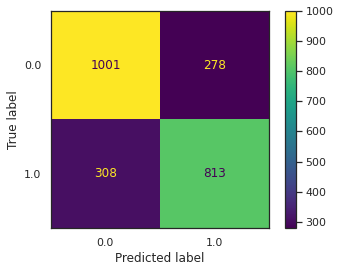

In [22]:
# Confusion Matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(gnb_fit, X_test, y_test)
plt.show()

# Results Analysis
As we can see the acurracity when we assign 60% of the dataset to test and we use Naive Bayes model to predict the battle is around 75%, it means that we will predict correctly 3/4 of the battles.

According to the confusion matrix, as we can see In row 0 there are 12607 points, but only 9773 are correctly allocated to 0 and 2834 are incorrectly assigned to 1. In row 1 there are 11393 points, but only 8447 are correctly allocated to 1 and 2946 are incorrectly apportioned to 0. It seems that the model prediction fails a little more when we extect win.

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [23]:
# Your code here...

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [27]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

processing_df = data
processing_df['Wins'] = processing_df['Wins'].astype('Int64')
req_cols =['Name', 'Type 1', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Name__other', 'Type 1__other', 'HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other', 'Wins']

cat_cols = ['Name','Name__other','Type 1','Type 1__other']
num_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed','HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other']

pipeline = Pipeline(steps=[
    ("selector", ColumnTransformer([
        ("selector","passthrough",req_cols),
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", SimpleImputer(strategy="most_frequent"), cat_cols)
     ], remainder="drop"))
])


X, y = get_Xy(processing_df) # X = features , y = target (Win/Loss)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=0)

 
pipeline.fit_transform(processing_df)

array([[262.0, 10.0, 100.0, ..., 278.0, 10.0, 10.0],
       [457.0, 12.0, 95.0, ..., 555.0, 12.0, 17.0],
       [488.0, 6.0, 60.0, ..., 10.0, 6.0, 17.0],
       ...,
       [nan, 15.0, 50.0, ..., 701.0, 15.0, 8.0],
       [717.0, 11.0, 51.0, ..., 77.0, 11.0, 17.0],
       [227.0, 8.0, 60.0, ..., 632.0, 8.0, 9.0]], dtype=object)